In [1]:
import matplotlib
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence
 
 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

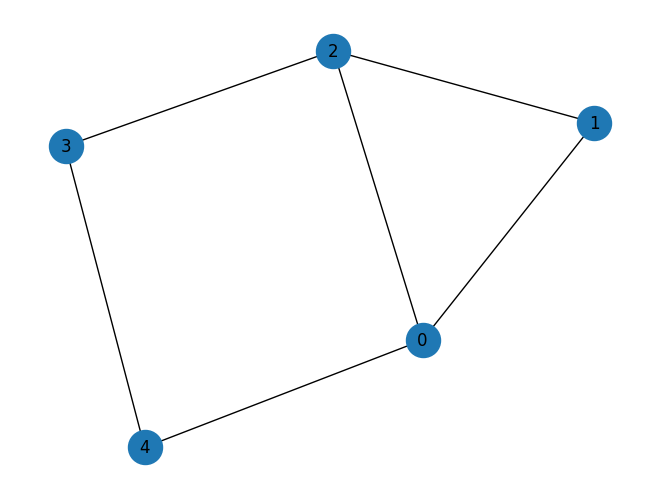

In [2]:
n = 5
 
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [3]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.
 
    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list
 
 
max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


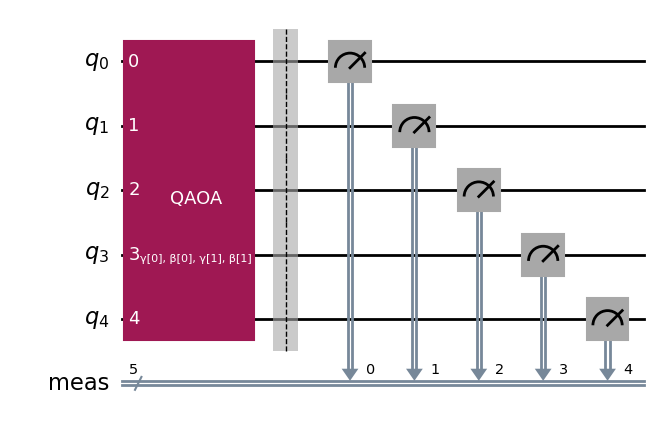

In [4]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()
 
circuit.draw("mpl")

In [5]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

qiskit_runtime_service.__init__:WARNING:2026-01-02 13:32:24,467: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-01-02 13:32:25,251: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2026-01-02 13:32:27,443: Using instance: open-instance, plan: open


<IBMBackend('ibm_fez')>


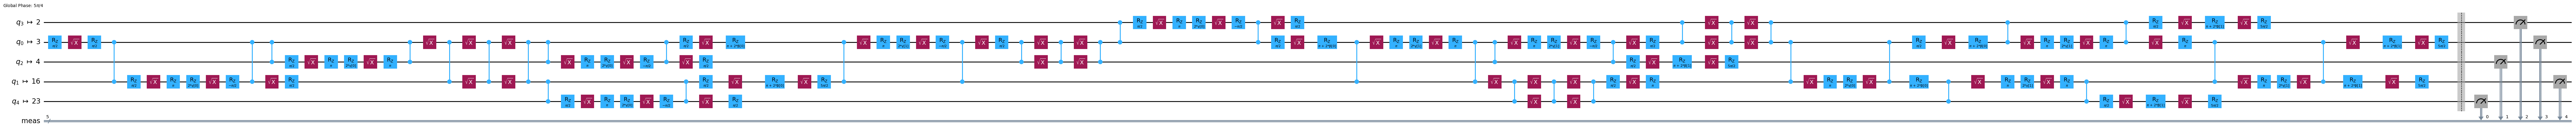

In [6]:
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
print(backend)
 
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
 
candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [7]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

In [8]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
 
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
 
    results = job.result()[0]
    cost = results.data.evs
 
    objective_func_vals.append(cost)
 
    return cost

In [9]:
objective_func_vals = []  # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000
 
    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
 
    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

RequestsApiError: '400 Client Error: Bad Request for url: https://quantum.cloud.ibm.com/api/v1/sessions. {"errors":[{"code":1352,"message":"You are not authorized to run a session when using the open plan.","solution":"Create an instance of a different plan type or use a different [execution mode](https://quantum.cloud.ibm.com/docs/guides/execution-modes).","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"d5dd08d2-b483-41e9-8d88-e8d2949afe66"}\n'

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()